In [1]:
from google.colab import drive, output
drive.mount('/content/drive')
import sys
%cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
#sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
#sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
%load_ext autoreload
%autoreload 1
!pip install torchaudio
!pip install wandb --upgrade
!wandb login
output.clear()

In [2]:
from __future__ import print_function
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

from six.moves import xrange

#import umap
import wandb
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.empty_cache()

from scipy import signal
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from torch.utils.data import random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader import SoundscapeData
from Models import Model
from Models import Encoder
from Models import Decoder
from Models import VectorQuantizer
from Models import VectorQuantizerEMA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

from datetime import timedelta
import wandb
from wandb import AlertLevel

wandb.login()

cuda


wandb: Currently logged in as: danielnieto (use `wandb login --relogin` to force relogin)


True

## Train

We use the hyperparameters from the author's code:

In [3]:
root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Jaguas_2018'


dataset = SoundscapeData(root_path, 1, "wav")
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.0250), len(dataset) - round(len(dataset)*0.0250)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "batch_size" : 18,
    "num_epochs": 15,
    "num_training_updates" : len(dataset_train),
    "num_hiddens" : 64,
    "embedding_dim" : 128,
    "num_embeddings" : 64,
    "commitment_cost" : 0.25,
    "decay" : 0.99,
    "learning_rate" : 1e-3,
    "dataset": "Audios Humboldt",
    "architecture": "VQ-VAE",
}

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])


model = Model(config["num_hiddens"],
              config["num_embeddings"], config["embedding_dim"], 
              config["commitment_cost"], config["decay"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)


wandb.finish()
wandb.init(project="VQ-VAE-Jaguas", config=config)
wandb.watch(model)


[]

In [4]:
def testModel(model, iterator):
    model.eval()
    (valid_originals, _,_) = next( iterator)
    valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1], 
                                                  valid_originals.shape[2], valid_originals.shape[3]))
    valid_originals = torch.unsqueeze(valid_originals,1)

    valid_originals = valid_originals.to(device)

    vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)
    output =  torch.cat((valid_originals[0:8], valid_reconstructions[0:8]), 0)
    img_grid = make_grid(output,nrow= 8,pad_value=20)

    recon_error = F.mse_loss(valid_originals, valid_reconstructions)

    fig, ax = plt.subplots(figsize=(20,5))
    ax.imshow(img_grid[1,:,:].cpu(), vmin=0,vmax=1)
    ax.axis("off")
    plt.show()
    return fig, recon_error


torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 1 of 502 	 loss: 148.1181 	 recon_error: 147.9557 	 vq_loss: 0.1623
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 2 of 502 	 loss: 147.954 	 recon_error: 147.9526 	 vq_loss: 0.0014
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 3 of 502 	 loss: 147.9506 	 recon_error: 147.9498 	 vq_loss: 0.0008
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 4 of 502 	 loss: 147.9474 	 recon_error: 147.9469 	 vq_loss: 0.0005
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 5 of 502 	 loss: 147.9446 	 recon_error: 147.944 	 vq_loss: 0.0006
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 6 of 502 	 loss: 147.9422 	 recon_error: 147.9407 	 vq_loss: 0.0015
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 7 of 502 	 loss: 147.9406 	 recon_error: 147.9358 	 vq_loss: 0.0048
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 8 of 502 	 loss: 147.944 	 recon_error: 147.92

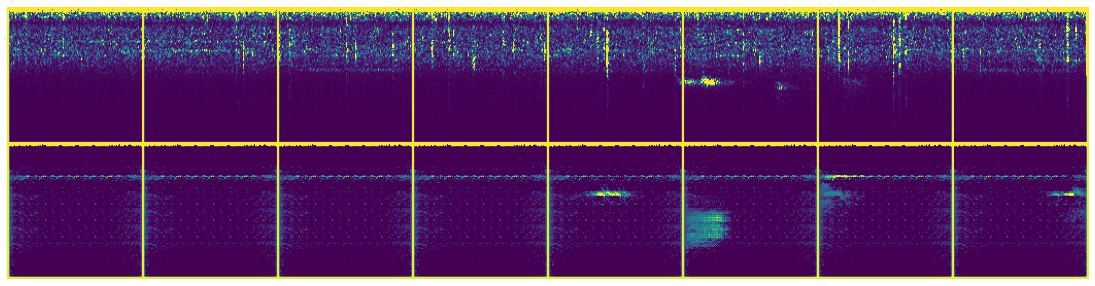

torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 101 of 502 	 loss: 66.7553 	 recon_error: 57.0309 	 vq_loss: 9.7244
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 102 of 502 	 loss: 64.5229 	 recon_error: 53.8657 	 vq_loss: 10.6572
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 103 of 502 	 loss: 63.1023 	 recon_error: 52.6441 	 vq_loss: 10.4582
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 104 of 502 	 loss: 61.5657 	 recon_error: 51.8713 	 vq_loss: 9.6945
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 105 of 502 	 loss: 60.3047 	 recon_error: 51.316 	 vq_loss: 8.9887
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 106 of 502 	 loss: 58.4546 	 recon_error: 50.0927 	 vq_loss: 8.3619
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 107 of 502 	 loss: 56.7008 	 recon_error: 48.485 	 vq_loss: 8.2158
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 108 of 502 	 loss: 54.8619 	 recon_error: 46

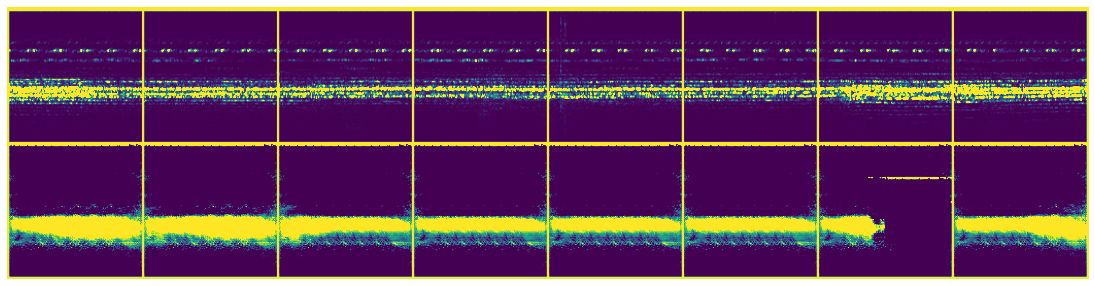

torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 201 of 502 	 loss: 43.5831 	 recon_error: 36.6065 	 vq_loss: 6.9766
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 202 of 502 	 loss: 42.546 	 recon_error: 35.4534 	 vq_loss: 7.0926
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 203 of 502 	 loss: 43.1886 	 recon_error: 36.0899 	 vq_loss: 7.0987
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 204 of 502 	 loss: 42.4304 	 recon_error: 35.636 	 vq_loss: 6.7944
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 205 of 502 	 loss: 41.1996 	 recon_error: 34.9025 	 vq_loss: 6.2972
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 206 of 502 	 loss: 40.6742 	 recon_error: 34.8623 	 vq_loss: 5.8119
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 207 of 502 	 loss: 40.0471 	 recon_error: 34.766 	 vq_loss: 5.2812
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 208 of 502 	 loss: 43.2107 	 recon_error: 38.50

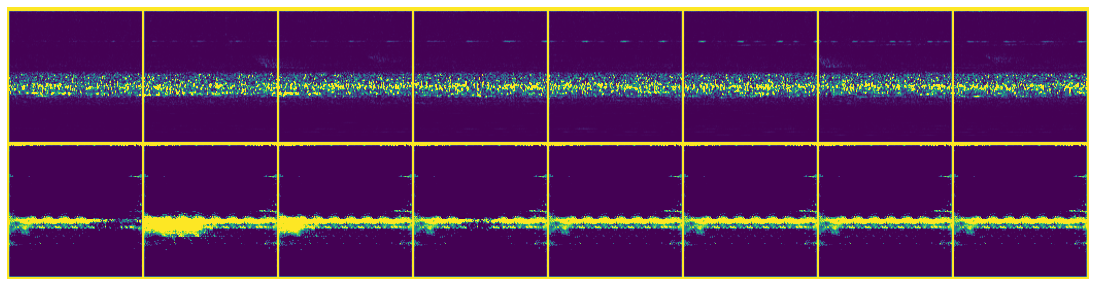

torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 301 of 502 	 loss: 41.6054 	 recon_error: 37.3504 	 vq_loss: 4.255
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 302 of 502 	 loss: 40.9691 	 recon_error: 36.8197 	 vq_loss: 4.1493
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 303 of 502 	 loss: 40.3714 	 recon_error: 36.2248 	 vq_loss: 4.1465
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 304 of 502 	 loss: 39.7424 	 recon_error: 35.6284 	 vq_loss: 4.114
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 305 of 502 	 loss: 38.897 	 recon_error: 34.9342 	 vq_loss: 3.9629
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 306 of 502 	 loss: 39.2357 	 recon_error: 35.5006 	 vq_loss: 3.7351
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 307 of 502 	 loss: 38.8261 	 recon_error: 35.1631 	 vq_loss: 3.6631
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 308 of 502 	 loss: 38.4924 	 recon_error: 34.74

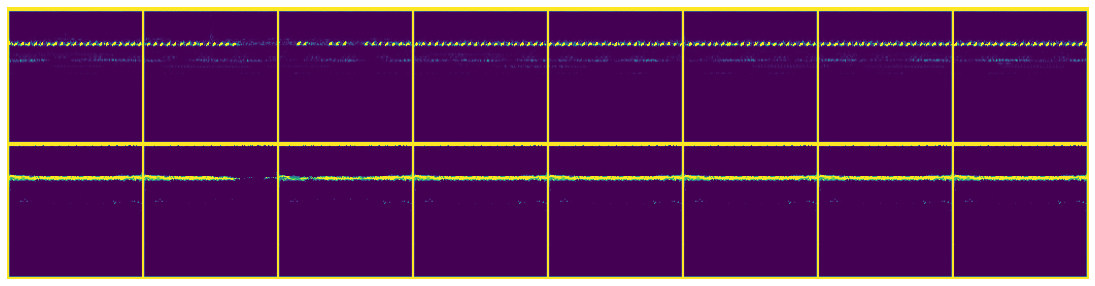

torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 401 of 502 	 loss: 23.655 	 recon_error: 20.3866 	 vq_loss: 3.2685
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 402 of 502 	 loss: 23.124 	 recon_error: 19.6957 	 vq_loss: 3.4282
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 403 of 502 	 loss: 33.7722 	 recon_error: 30.2564 	 vq_loss: 3.5158
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 404 of 502 	 loss: 31.5274 	 recon_error: 28.1621 	 vq_loss: 3.3654
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 405 of 502 	 loss: 23.0176 	 recon_error: 19.6597 	 vq_loss: 3.3579
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 406 of 502 	 loss: 22.7076 	 recon_error: 19.125 	 vq_loss: 3.5826
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 407 of 502 	 loss: 31.2469 	 recon_error: 27.4708 	 vq_loss: 3.7761
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 408 of 502 	 loss: 28.0403 	 recon_error: 24.19

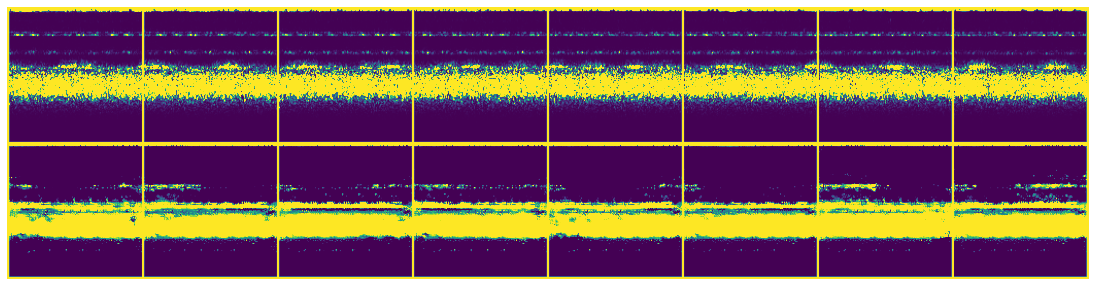

torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 501 of 502 	 loss: 14.3023 	 recon_error: 11.5688 	 vq_loss: 2.7336
torch.Size([1062, 1, 129, 129])
epoch: 0 of 15 	 iteration: 502 of 502 	 loss: 14.264 	 recon_error: 11.5408 	 vq_loss: 2.7233
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 1 of 502 	 loss: 14.2111 	 recon_error: 11.5101 	 vq_loss: 2.701
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 2 of 502 	 loss: 14.1646 	 recon_error: 11.4868 	 vq_loss: 2.6778
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 3 of 502 	 loss: 14.1209 	 recon_error: 11.4601 	 vq_loss: 2.6607
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 4 of 502 	 loss: 14.0854 	 recon_error: 11.4433 	 vq_loss: 2.6421
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 5 of 502 	 loss: 14.0389 	 recon_error: 11.4322 	 vq_loss: 2.6067
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 6 of 502 	 loss: 13.9607 	 recon_error: 11.3942 	 vq_los

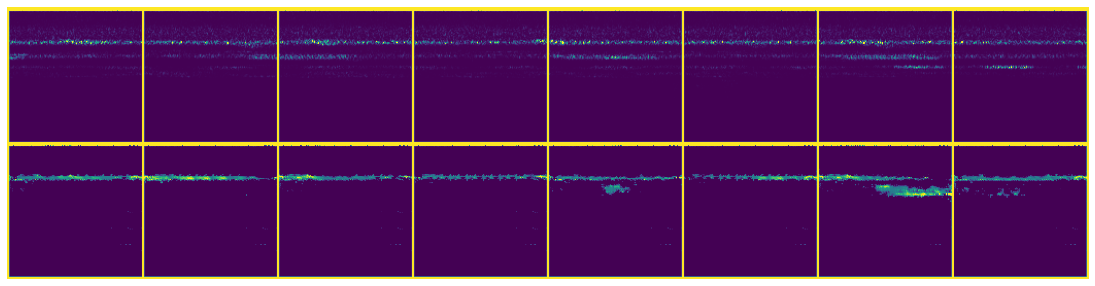

torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 101 of 502 	 loss: 11.2835 	 recon_error: 9.2984 	 vq_loss: 1.9851
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 102 of 502 	 loss: 11.1522 	 recon_error: 9.1792 	 vq_loss: 1.973
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 103 of 502 	 loss: 11.1099 	 recon_error: 9.1523 	 vq_loss: 1.9576
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 104 of 502 	 loss: 11.1564 	 recon_error: 9.2175 	 vq_loss: 1.9388
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 105 of 502 	 loss: 11.0997 	 recon_error: 9.1738 	 vq_loss: 1.9259
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 106 of 502 	 loss: 10.961 	 recon_error: 9.0447 	 vq_loss: 1.9163
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 107 of 502 	 loss: 10.9586 	 recon_error: 9.0494 	 vq_loss: 1.9093
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 108 of 502 	 loss: 10.9225 	 recon_error: 9.0211 	 vq

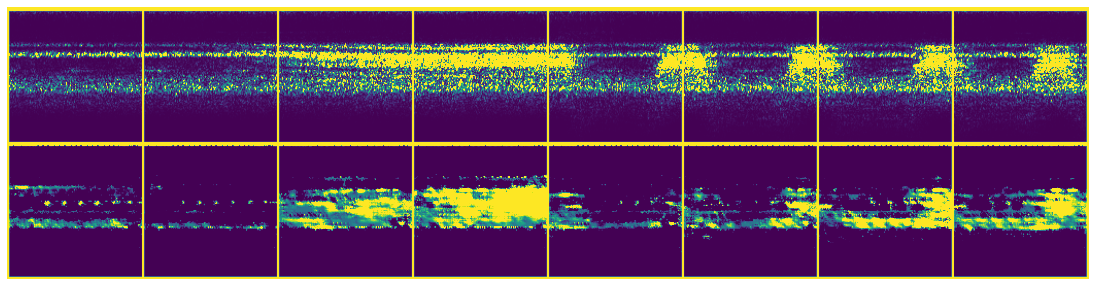

torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 201 of 502 	 loss: 9.4843 	 recon_error: 7.7636 	 vq_loss: 1.7207
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 202 of 502 	 loss: 9.4215 	 recon_error: 7.7363 	 vq_loss: 1.6852
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 203 of 502 	 loss: 9.4063 	 recon_error: 7.7375 	 vq_loss: 1.6688
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 204 of 502 	 loss: 9.3845 	 recon_error: 7.715 	 vq_loss: 1.6695
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 205 of 502 	 loss: 9.3583 	 recon_error: 7.7027 	 vq_loss: 1.6556
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 206 of 502 	 loss: 9.6119 	 recon_error: 7.9929 	 vq_loss: 1.619
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 207 of 502 	 loss: 9.474 	 recon_error: 7.8648 	 vq_loss: 1.6092
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 208 of 502 	 loss: 9.5636 	 recon_error: 7.97 	 vq_loss: 1.59

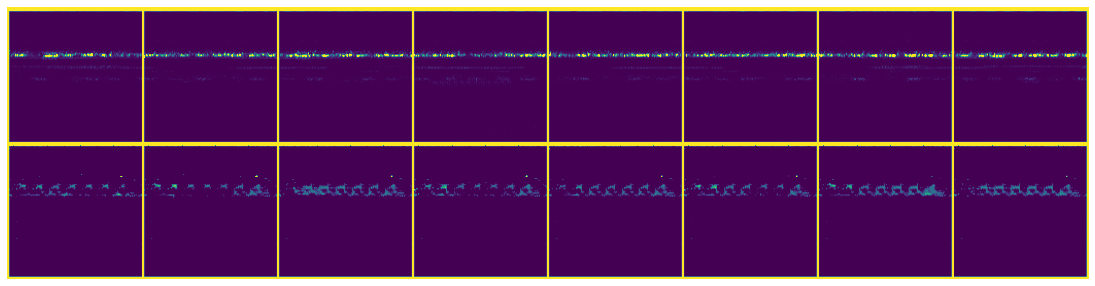

torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 301 of 502 	 loss: 7.622 	 recon_error: 6.7214 	 vq_loss: 0.9006
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 302 of 502 	 loss: 7.5735 	 recon_error: 6.6745 	 vq_loss: 0.899
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 303 of 502 	 loss: 7.5502 	 recon_error: 6.653 	 vq_loss: 0.8972
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 304 of 502 	 loss: 7.5286 	 recon_error: 6.6312 	 vq_loss: 0.8975
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 305 of 502 	 loss: 7.5047 	 recon_error: 6.6097 	 vq_loss: 0.8951
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 306 of 502 	 loss: 7.487 	 recon_error: 6.5997 	 vq_loss: 0.8874
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 307 of 502 	 loss: 7.818 	 recon_error: 6.9384 	 vq_loss: 0.8796
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 308 of 502 	 loss: 7.7364 	 recon_error: 6.8561 	 vq_loss: 0.88

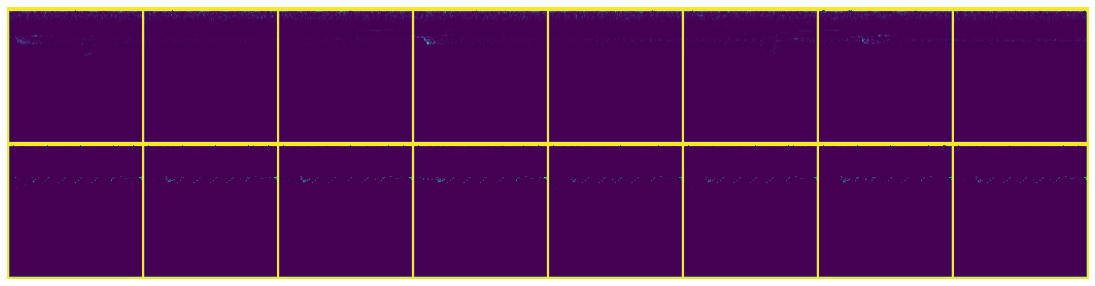

torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 401 of 502 	 loss: 6.5868 	 recon_error: 5.7969 	 vq_loss: 0.7899
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 402 of 502 	 loss: 6.793 	 recon_error: 5.981 	 vq_loss: 0.812
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 403 of 502 	 loss: 6.6876 	 recon_error: 5.8833 	 vq_loss: 0.8043
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 404 of 502 	 loss: 6.634 	 recon_error: 5.8543 	 vq_loss: 0.7797
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 405 of 502 	 loss: 6.5642 	 recon_error: 5.8037 	 vq_loss: 0.7605
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 406 of 502 	 loss: 6.522 	 recon_error: 5.7727 	 vq_loss: 0.7493
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 407 of 502 	 loss: 6.5498 	 recon_error: 5.8133 	 vq_loss: 0.7366
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 408 of 502 	 loss: 6.6304 	 recon_error: 5.9068 	 vq_loss: 0.72

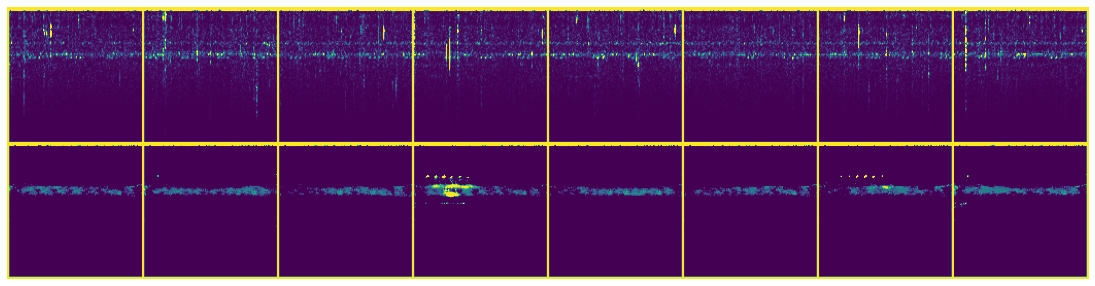

torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 501 of 502 	 loss: 5.8897 	 recon_error: 5.3524 	 vq_loss: 0.5373
torch.Size([1062, 1, 129, 129])
epoch: 1 of 15 	 iteration: 502 of 502 	 loss: 5.8802 	 recon_error: 5.3436 	 vq_loss: 0.5367
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 1 of 502 	 loss: 5.8738 	 recon_error: 5.3376 	 vq_loss: 0.5362
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 2 of 502 	 loss: 5.7967 	 recon_error: 5.2607 	 vq_loss: 0.536
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 3 of 502 	 loss: 5.8015 	 recon_error: 5.266 	 vq_loss: 0.5356
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 4 of 502 	 loss: 5.796 	 recon_error: 5.2611 	 vq_loss: 0.5349
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 5 of 502 	 loss: 5.786 	 recon_error: 5.2513 	 vq_loss: 0.5347
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 6 of 502 	 loss: 5.9851 	 recon_error: 5.4496 	 vq_loss: 0.5355
torch.Si

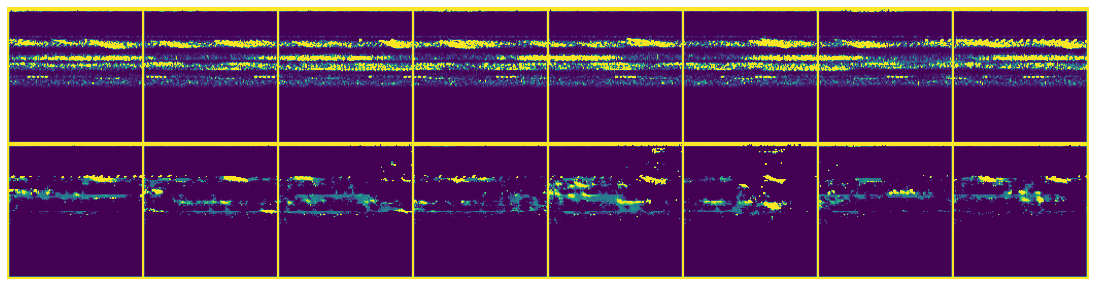

torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 101 of 502 	 loss: 5.2379 	 recon_error: 4.8148 	 vq_loss: 0.423
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 102 of 502 	 loss: 5.2238 	 recon_error: 4.8015 	 vq_loss: 0.4223
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 103 of 502 	 loss: 5.2289 	 recon_error: 4.8068 	 vq_loss: 0.4221
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 104 of 502 	 loss: 5.2292 	 recon_error: 4.8072 	 vq_loss: 0.422
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 105 of 502 	 loss: 5.3462 	 recon_error: 4.9244 	 vq_loss: 0.4218
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 106 of 502 	 loss: 5.3324 	 recon_error: 4.9085 	 vq_loss: 0.4239
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 107 of 502 	 loss: 5.214 	 recon_error: 4.7883 	 vq_loss: 0.4258
torch.Size([1062, 1, 129, 129])
epoch: 2 of 15 	 iteration: 108 of 502 	 loss: 5.1925 	 recon_error: 4.7672 	 vq_loss: 0.

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []
iterator = iter(test_loader)
wandb.watch(model, F.mse_loss, log="all", log_freq=1)
error_files = []

for epoch in range(config["num_epochs"]):
  for i in xrange(config["num_training_updates"]):
      model.train()
      try:
         (data, _,_) = next(iter(training_loader))
      except:
        error_files.append[i]
        continue
          
      data = torch.reshape(data, (data.shape[0] * data.shape[1], data.shape[2], data.shape[3]))
      data = torch.unsqueeze(data,1)
      data = data.to(device)
      
      
      optimizer.zero_grad()
      vq_loss, data_recon, perplexity = model(data)
      print(data_recon.shape)
      
      recon_error = F.mse_loss(data_recon, data) #/ data_variance
      loss = recon_error + vq_loss
      loss.backward()

      optimizer.step()

      wandb.log({"loss":loss.item(),
                 "perplexity":perplexity.item(),
                 "recon_error": recon_error,
                 "vq_loss": vq_loss})
      print(f'epoch: {epoch} of {config["num_epochs"]} \t iteration: {(i+1)} of {config["num_training_updates"]} \t loss: {np.round(loss.item(),4)} \t recon_error: {np.round(recon_error.item(),4)} \t vq_loss: {np.round(vq_loss.item(),4)}')
      # torch.cuda.empty_cache()
      # import gc
      # gc.collect()
      # torch.cuda.empty_cache()
      
      if (i+1) % 100 == 0:
        #torch.save(model.state_dict(),f'model_{epoch}_{i}.pkl')
        fig, test_error = testModel(model, iterator)
        images = wandb.Image(fig, caption= f"recon_error: {np.round(test_error.item(),4)}")
        wandb.log({"examples": images})
        #wandb.log({"config": config})

      if recon_error < 3:
        wandb.alert(
          title='High accuracy',
          text=f'Recon error {recon_error} is lower than 5',
          level=AlertLevel.WARN,
          wait_duration=timedelta(minutes=5)
                    )
                  
wandb.finish()


In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.save(model.state_dict(),f'model_{epoch}_{i}.pkl')

In [ ]:
model.load_state_dict(torch.load('model_1_12999_5s.pkl', map_location=torch.device('cpu')))

## Plot Loss

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [ ]:
model.eval()
validation_loader = training_loader
(valid_originals, _,_,_) = next(iter(validation_loader),30000)

## View Reconstructions

In [ ]:
model.eval()
validation_loader = training_loader
(valid_originals, _,_,_) = next(iter(validation_loader),3000)
valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1], valid_originals.shape[2], valid_originals.shape[3]))
valid_originals = torch.unsqueeze(valid_originals,1)

print(valid_originals.shape)



valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [ ]:
def showTensor(tensor, dim):
    return tensor[dim,:,:,:].cpu().detach().numpy()[0,:,:]

In [ ]:
plt.figure(figsize=(40,40))

plt.subplot(5,2,1)
plt.imshow(showTensor(valid_originals,0),vmin=0,vmax=0.7)
plt.subplot(5,2,2)
plt.imshow(showTensor(valid_reconstructions,0),vmin=0,vmax=0.7)
plt.subplot(5,2,3)
plt.imshow(showTensor(valid_originals,1),vmin=0,vmax=0.7)
plt.subplot(5,2,4)
plt.imshow(showTensor(valid_reconstructions,1),vmin=0,vmax=0.7)
plt.subplot(5,2,5)
plt.imshow(showTensor(valid_originals,2),vmin=0,vmax=0.7)
plt.subplot(5,2,6)
plt.imshow(showTensor(valid_reconstructions,2),vmin=0,vmax=0.7)
plt.subplot(5,2,7)
plt.imshow(showTensor(valid_originals,3),vmin=0,vmax=0.7)
plt.subplot(5,2,8)
plt.imshow(showTensor(valid_reconstructions,3),vmin=0,vmax=0.7)
plt.subplot(5,2,9)
plt.imshow(showTensor(valid_originals,4),vmin=0,vmax=0.7)
plt.subplot(5,2,10)
plt.imshow(showTensor(valid_reconstructions,4),vmin=0,vmax=0.7)
#plt.savefig("VQVAE_Sin_Residual.pdf")

In [ ]:
(train_originals, _,_,_) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [ ]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [ ]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

In [ ]:
show(make_grid(valid_originals.cpu()+0.5))

## View Embedding

In [ ]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)